## Preset of the data

* path = 'project path'           
    ' \\ ' need to change to ' \\\\ ' to avoid error
    

* base = 'base atom of the data prefix'


* enDisp = energy dispersion value given by energy calibration,
    
    unit = eV/subpixel
    

In [1]:
%pylab agg
%matplotlib nbagg

import h5py

from scipy.signal import correlate
from scipy.signal import find_peaks
# from scipy.optimize import curve_fit

path = '/sls/X03MA/data/x03maop/Data1/RIXS/Asmara/'
base = 'O'
enDisp = 0.00457 #eV/subpixel

Populating the interactive namespace from numpy and matplotlib


## Function to get XAS data

input scannumber
output Energy,TEY,TFY,RMU

In [2]:
def get_xas(scannumber):
    global path
    global base
    if scannumber < 10:
        filename = base+"_"+"000"+str(scannumber)
    elif scannumber < 100:
        filename = base+"_"+"00"+str(scannumber)
    elif scannumber < 1000:    
        filename = base+"_"+"0"+str(scannumber)
    else:    
        filename = base+"_"+str(scannumber)
    data = loadtxt(path+"XAS/"+filename+".xas",comments="#")
    Energy = data[:,0]
    TEY = data[:,1]
    TFY = data[:,2]
    RMU = data[:,3]
    
    return Energy,TEY,TFY,RMU


## Fucntion to get RIXS data

### x_corr 

Used to calculate correlation between reference data and new data. 

It could be zoomed into elastic region to get better resolution.

### elastic_shift 

shift the elastic peak to zero

* find_peak try to find elastic peak as a peak shape

    following parameter could be used to specify the peak
    
    height=None, threshold=None, distance=None, prominence=None, width=None, wlen=None, rel_height=0.5, plateau_size=None


* or find peak with some constant value

the data has been zoomed into [-2000, 200]

### get_rixs

get a single data, input is scan number, output is E loss,intensity

### combine_rixs

get multiple data and combined, input is list of scan number, output is E loss and intensity

In [3]:
def x_corr(refData, uncorrData):

    corr = correlate(refData, uncorrData)
    lag = argmax(corr)
    corrData = roll(uncorrData, lag)

    return corrData

def elastic_shift(pixelData):

    global enDisp
    xdataPixel = arange(len(pixelData))
    
    peaks, _ = find_peaks(pixelData,height=10,width=3)     #try to find peak
#     peaks = xdataPixel[pixelData>50]    #try to find peak with right edge

    xdataPixel = xdataPixel[(peaks[-1]-2000):(peaks[-1]+200)]
    energyData = pixelData[(peaks[-1]-2000):(peaks[-1]+200)]
    xDataEnergy = (xdataPixel - peaks[-1]) * enDisp

    return xDataEnergy,energyData

def get_rixs(scannumber):

    global path
    global base
    if scannumber < 10:
        filename = base+"_"+"000"+str(scannumber)
    elif scannumber < 100:
        filename = base+"_"+"00"+str(scannumber)
    elif scannumber < 1000:    
        filename = base+"_"+"0"+str(scannumber)
    else:    
        filename = base+"_"+str(scannumber)
    f1 = h5py.File(path+"RIXS/"+filename+"_d1.h5", 'r')
    f2 = h5py.File(path+"RIXS/"+filename+"_d2.h5", 'r')
    f3 = h5py.File(path+"RIXS/"+filename+"_d3.h5", 'r')
    ccd1 = array(f1['entry']['analysis']['spectrum'][()])
    ccd2 = array(f2['entry']['analysis']['spectrum'][()])
    ccd3 = array(f3['entry']['analysis']['spectrum'][()])
    ccd1 = x_corr(ccd2,ccd1)
    ccd3 = x_corr(ccd2,ccd3)
    xdata,tempData = elastic_shift(ccd1+ccd2+ccd3)
    
    return xdata,tempData

def combine_rixs(scans):

    for i,scannumber in enumerate(scans):
        if i == 0:
            xdata,ydata = get_rixs(scannumber)
            refdata = ydata
            sumdata = ydata
        else:
            _,ydata = get_rixs(scannumber)
            ydata = x_corr(refdata,ydata)
            sumdata = sumdata+ydata
 
    return xdata,sumdata

## Example to plot XAS data

<IPython.core.display.Javascript object>


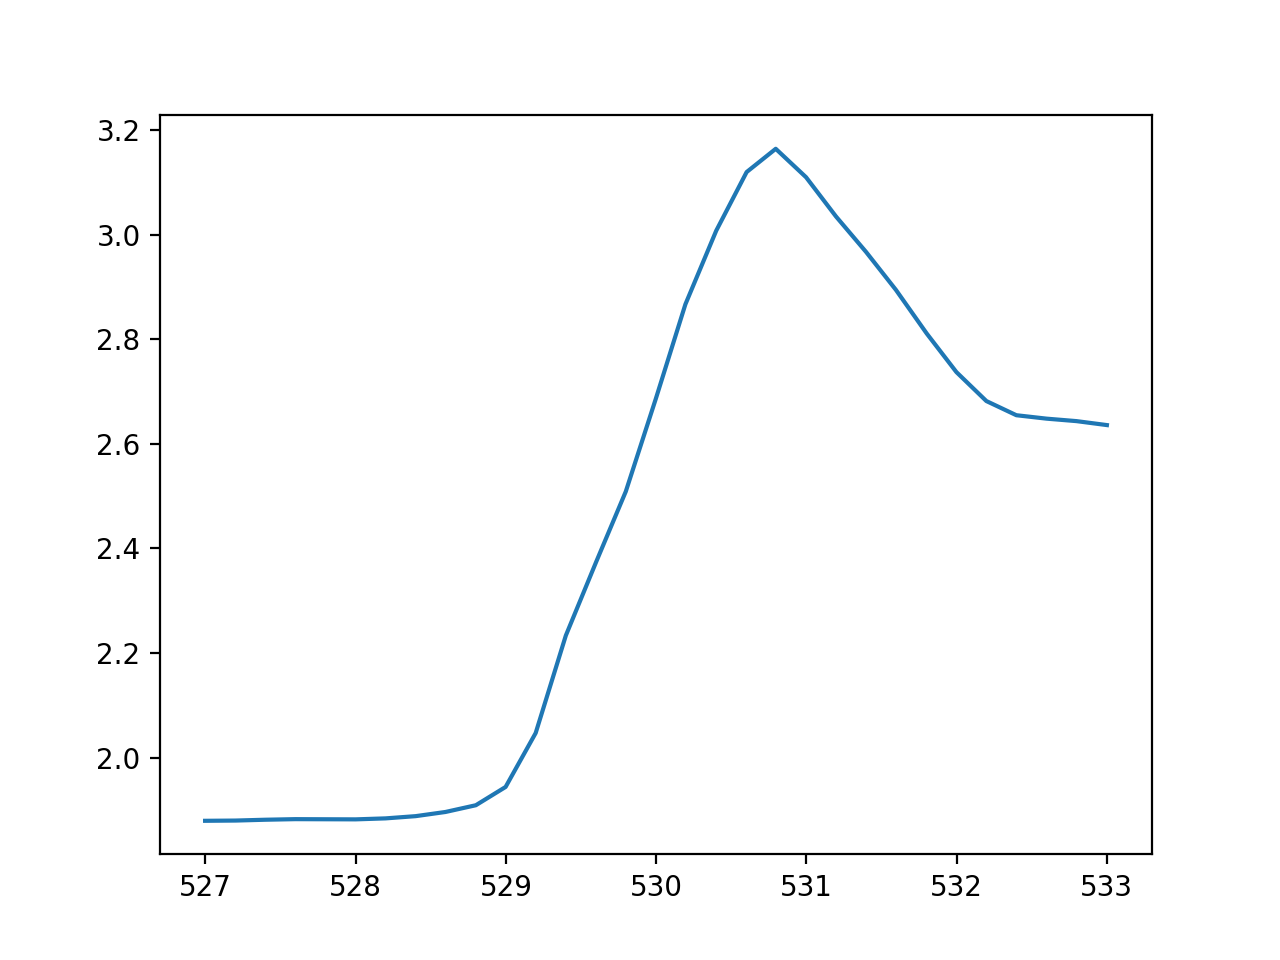

In [4]:
figure()
E,TEY,TFY,RMU = get_xas(2)
plot(E,TEY)

## Example to plot one RIXS acquire

<IPython.core.display.Javascript object>


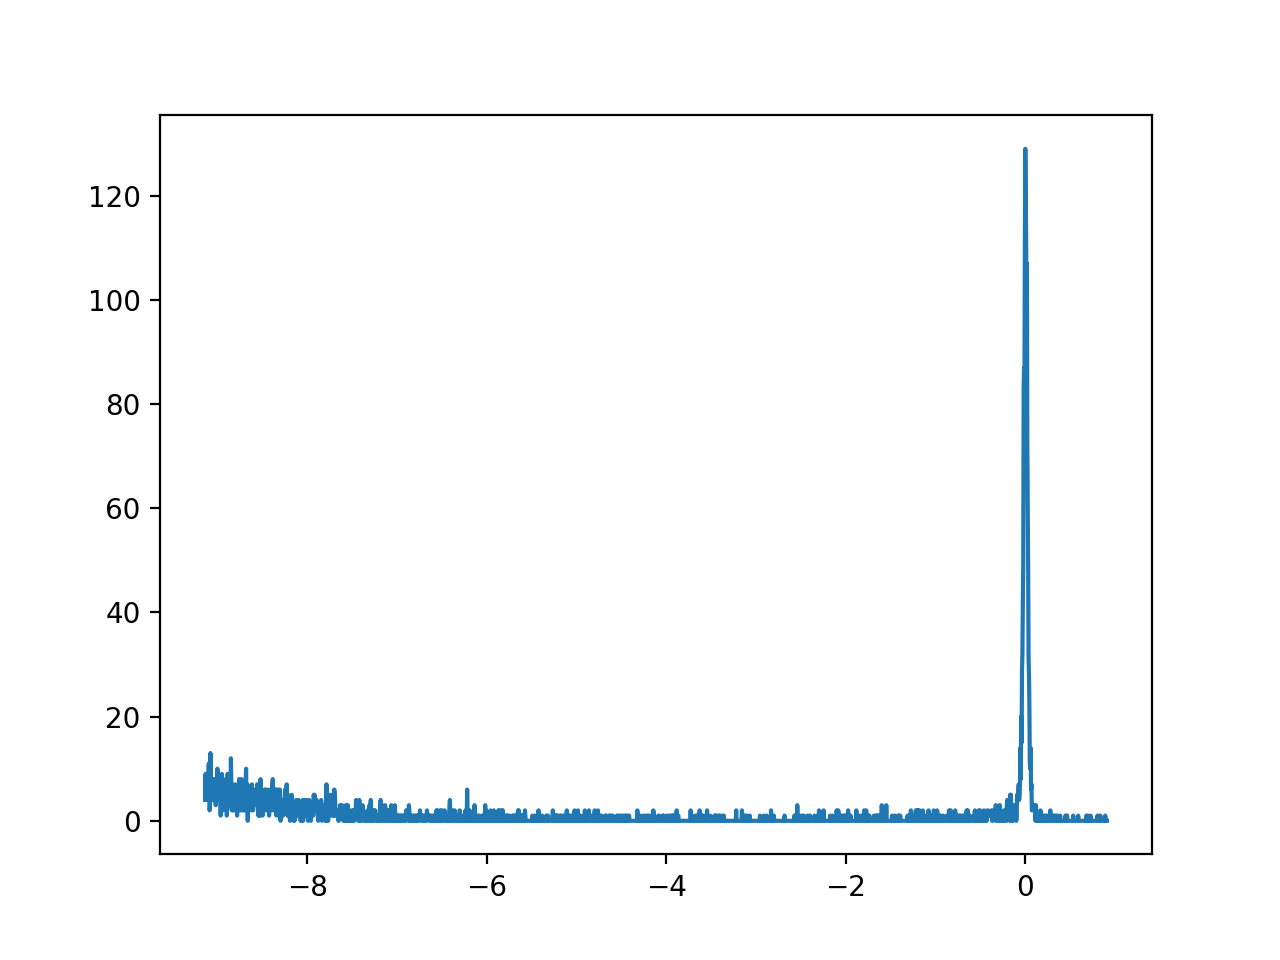

In [5]:
figure()
X,Y=get_rixs(28)
plot(X,Y);

## Example to combine and plot repeating RIXS data

<IPython.core.display.Javascript object>


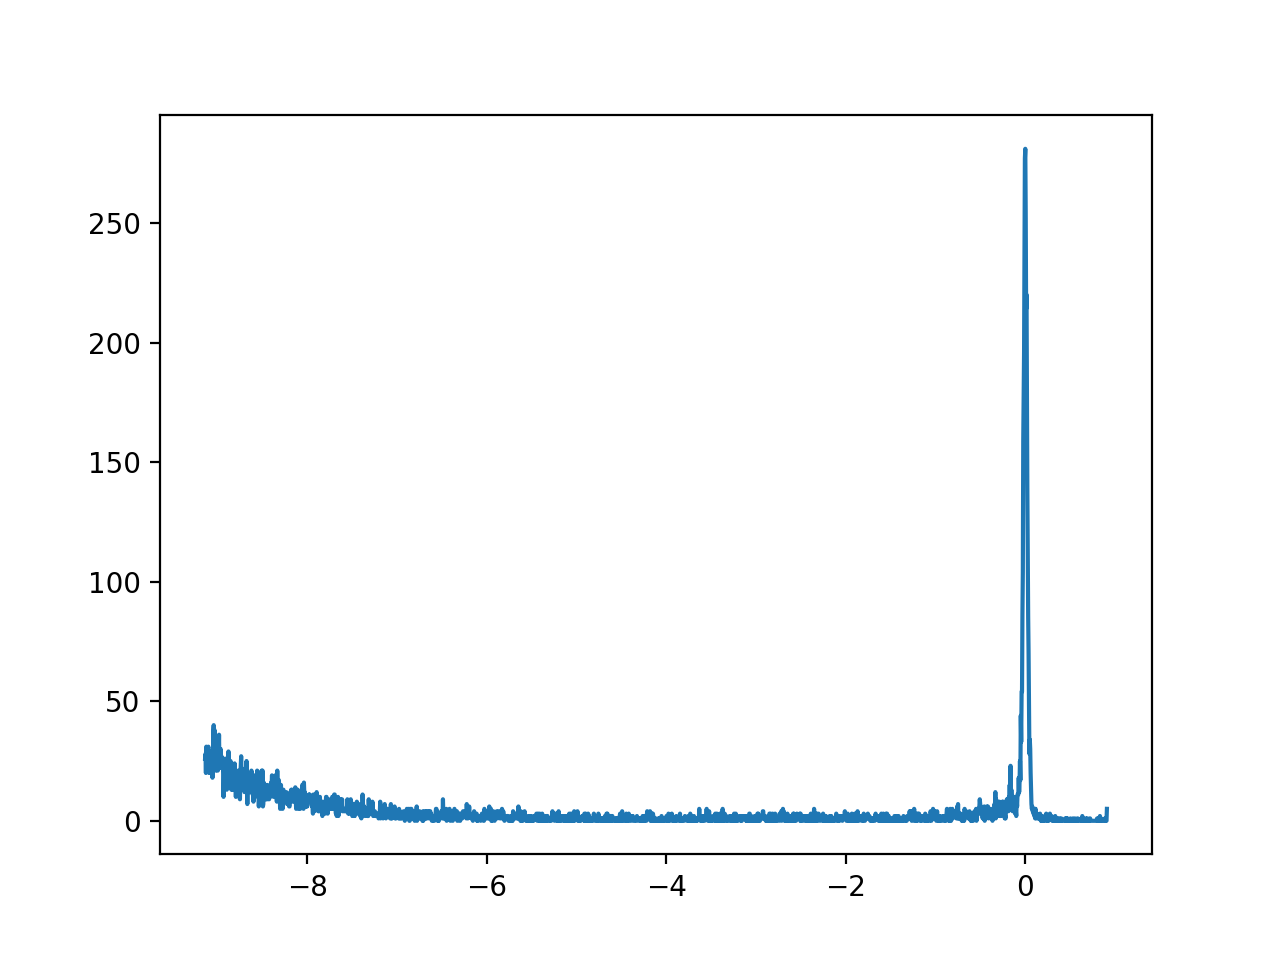

In [6]:
figure()
X,Y=combine_rixs([27,28])
plot(X,Y);